In [31]:
import jax
from jax import jit
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[3])
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})


# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
    GP_Sampler_1D_Pinned,
    setup_problem_data
)
# from plotting import plot_input_data

from KernelTools import diagpart
from evaluation_metrics import get_nrmse

In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2898.73it/s]


## Compute collocation points, insert sample points

In [3]:
num_grid_x = 26
num_grid_t = 26

#Build a collocation grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

tx_all = jnp.vstack([tx_bdy,tx_int])

#Observe on initial+final+boundary
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
u_true = u_true_function(tx_all)

x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
u_obs = u_true_function(tx_obs)


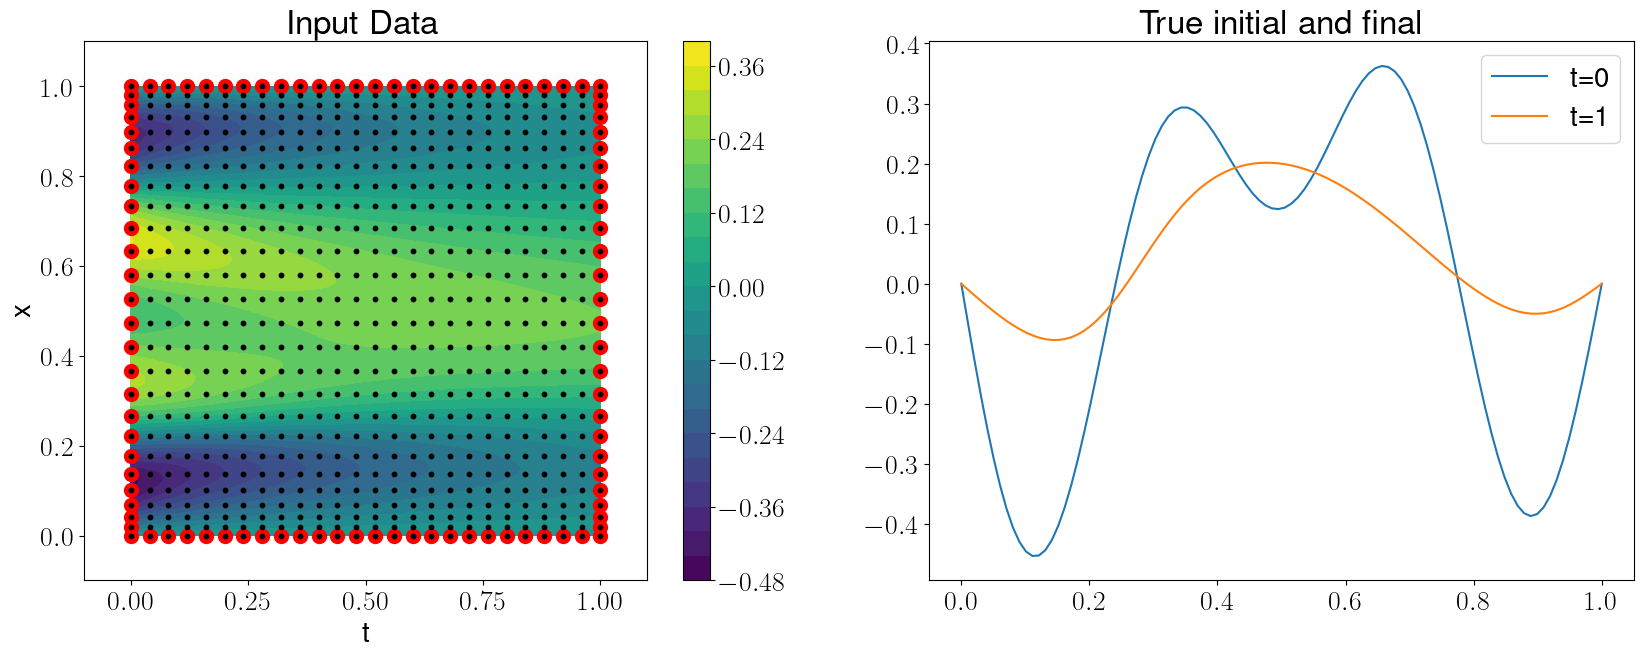

In [13]:
# num_fine_grid = 100
# final_time = 1
# t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
# tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

# plt.figure(figsize=(20,7))
# plt.subplot(1,2,1)
# plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
# plt.colorbar()
# plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
# plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 10)
# plt.xlabel("t")
# plt.ylabel("x")
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
# plt.title("Input Data")

# plt.subplot(1,2,2)
# plt.title("True initial and final")
# grid_points = jnp.linspace(0,1,num_fine_grid)
# plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
# plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
# plt.legend()
# plt.show()

## Setup model

In [58]:
# from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
# from Kernels import (
#     get_centered_scaled_poly_kernel,
#     get_gaussianRBF,
#     get_anisotropic_gaussianRBF
# )
# from KernelTools import eval_k,dx_k,dxx_k,dt_k


# u_operators = (eval_k,dx_k,dt_k,dxx_k)
# # u_operators = (eval_k,dx_k,dt_k)
# feature_operators = (eval_k,dx_k,dxx_k)

# k_u = get_gaussianRBF(jnp.sqrt(0.025/2))
# # k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,100])))

# u_model = CholInducedRKHS(
#     tx_all,
#     u_operators,
#     k_u,
#     nugget_size = 1e-8
#     )

# u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

# grid_features_init = (
#     (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
#     .reshape(
#             len(tx_int),
#             len(feature_operators),
#             order = 'F'
#         )
# )

# k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

# from KernelTools import vectorize_kfunc
# @vectorize_kfunc
# def k_P(x,y):
#     return 10*k_P_u_part(x[2:],y[2:])

# P_model = OperatorModel(k_P)
    

# EqnModel = OperatorPDEModel(
#     P_model,
#     (u_model,),
#     (tx_obs,),
#     (u_obs,),
#     (tx_int,),
#     feature_operators,
#     rhs_operator=dt_k,
#     datafit_weight = 100
# )

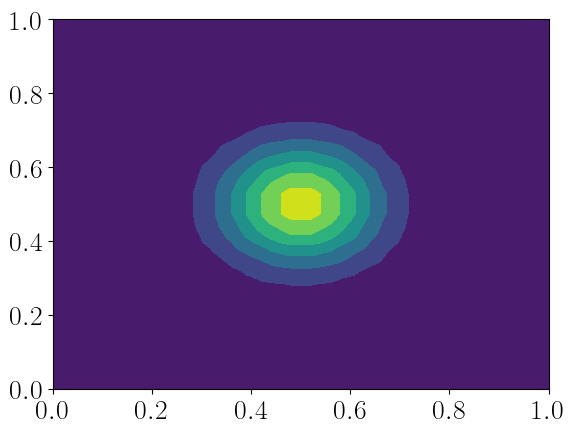

In [59]:
# plt.tricontourf(tx_all[:,0],tx_all[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.5]]),tx_all)[0])

In [60]:
# import Optimizers
# import importlib
# importlib.reload(Optimizers)
# from Optimizers import (
#     CholeskyLM,SVD_LM,LMParams,plot_optimization_results
# )

# optParams = LMParams(
#     max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

# params_init = jnp.hstack([u_params_init,jnp.zeros(EqnModel.num_operator_params)])

# params,convergence_data = CholeskyLM(
#     params_init.copy(),
#     EqnModel,
#     beta = 0.,
#     optParams=optParams
# )
# svd_params = LMParams(
#     max_iter=201,
#     init_alpha=convergence_data.alpha_vals[-1],
#     min_alpha=1e-16,print_every=50,
#     step_adapt_multiplier=1.6)


# p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,beta = 1e-16,optParams=svd_params)

  2%|▏         | 4/251 [00:28<22:32,  5.48s/it]  

Iteration 0, loss = 0.0922, gradnorm = 1.435e+03, alpha = 0.8543, improvement_ratio = 0.581
Iteration 1, loss = 0.04147, gradnorm = 2.096e+03, alpha = 0.8543, improvement_ratio = 0.7415
Iteration 2, loss = 0.01907, gradnorm = 308.5, alpha = 0.7119, improvement_ratio = 0.9331
Iteration 3, loss = 0.01214, gradnorm = 209.3, alpha = 0.5933, improvement_ratio = 0.9133
Iteration 4, loss = 0.00854, gradnorm = 222.1, alpha = 0.4944, improvement_ratio = 0.8785


  4%|▍         | 10/251 [00:29<05:53,  1.47s/it]

Iteration 5, loss = 0.005708, gradnorm = 281.7, alpha = 0.412, improvement_ratio = 0.9675


 22%|██▏       | 55/251 [00:30<00:08, 22.45it/s]

Iteration 50, loss = 4.194e-06, gradnorm = 4.712, alpha = 0.0001126, improvement_ratio = 0.9249


 42%|████▏     | 106/251 [00:32<00:05, 25.05it/s]

Iteration 100, loss = 3.61e-08, gradnorm = 0.3208, alpha = 2.139e-08, improvement_ratio = 0.504


 61%|██████▏   | 154/251 [00:34<00:04, 23.64it/s]

Iteration 150, loss = 1.253e-08, gradnorm = 0.03482, alpha = 1.522e-08, improvement_ratio = 0.6709


 82%|████████▏ | 205/251 [00:37<00:01, 23.17it/s]

Iteration 200, loss = 9.372e-09, gradnorm = 0.04866, alpha = 1.502e-08, improvement_ratio = 0.9983


100%|██████████| 251/251 [00:39<00:00,  6.41it/s]


Iteration 250, loss = 7.872e-09, gradnorm = 0.01524, alpha = 1.482e-08, improvement_ratio = 0.9987


  1%|          | 2/201 [00:24<32:51,  9.91s/it]  

Iteration 0, loss = 7.846e-09, gradnorm = 0.001706, alpha = 9.261e-09, improvement_ratio = 0.9997
Iteration 1, loss = 7.804e-09, gradnorm = 0.0007528, alpha = 5.788e-09, improvement_ratio = 0.9995


  2%|▏         | 4/201 [00:24<10:56,  3.33s/it]

Iteration 2, loss = 7.74e-09, gradnorm = 0.001884, alpha = 3.617e-09, improvement_ratio = 0.9988
Iteration 3, loss = 7.64e-09, gradnorm = 0.004679, alpha = 2.261e-09, improvement_ratio = 0.9967


  3%|▎         | 6/201 [00:24<04:46,  1.47s/it]

Iteration 4, loss = 7.489e-09, gradnorm = 0.01135, alpha = 1.413e-09, improvement_ratio = 0.9898
Iteration 5, loss = 7.272e-09, gradnorm = 0.02692, alpha = 8.832e-10, improvement_ratio = 0.9676


 26%|██▌       | 52/201 [00:29<00:16,  9.22it/s]

Iteration 50, loss = 2.229e-10, gradnorm = 0.09699, alpha = 2.167e-13, improvement_ratio = 0.9769


 51%|█████     | 102/201 [00:34<00:10,  9.23it/s]

Iteration 100, loss = 8.86e-11, gradnorm = 0.005374, alpha = 1.705e-13, improvement_ratio = 0.679


 76%|███████▌  | 152/201 [00:40<00:05,  9.22it/s]

Iteration 150, loss = 6.904e-11, gradnorm = 0.006057, alpha = 1.554e-13, improvement_ratio = 0.9856


100%|██████████| 201/201 [00:45<00:00,  4.41it/s]


Iteration 200, loss = 5.874e-11, gradnorm = 0.008551, alpha = 6.411e-14, improvement_ratio = 0.9219


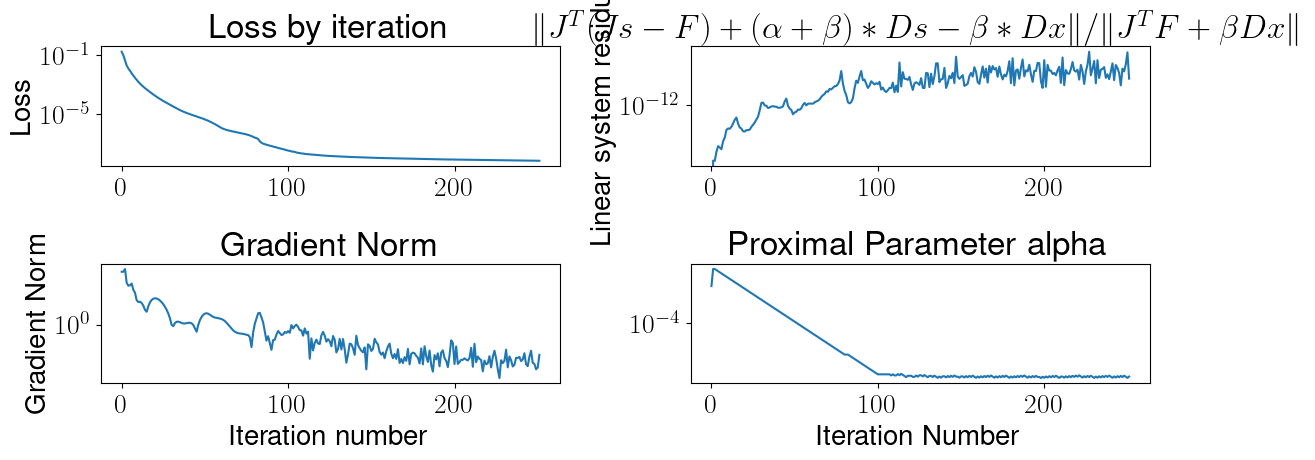

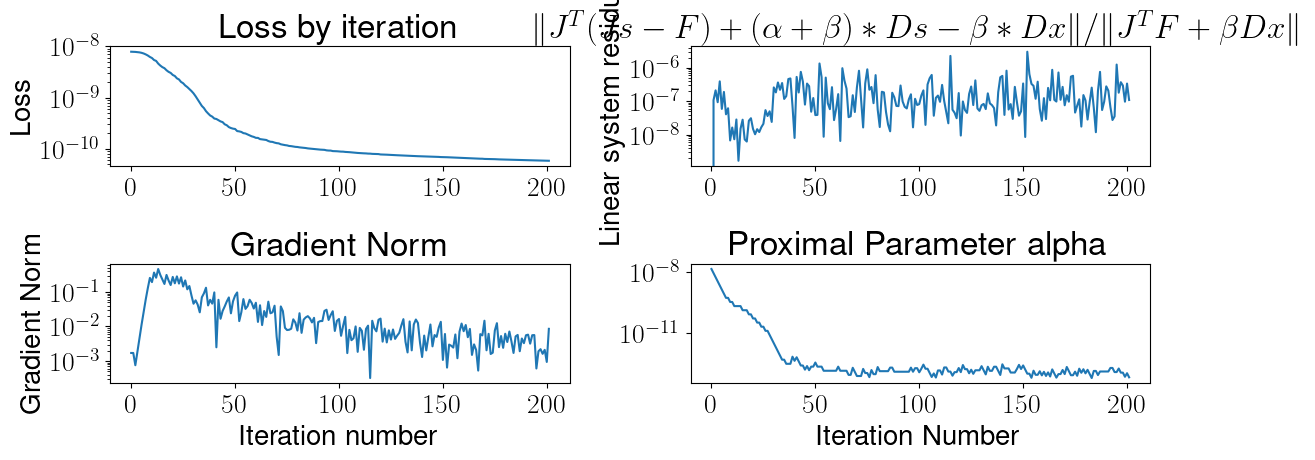

In [61]:
plot_optimization_results(convergence_data)
plot_optimization_results(refine_convergence_data)

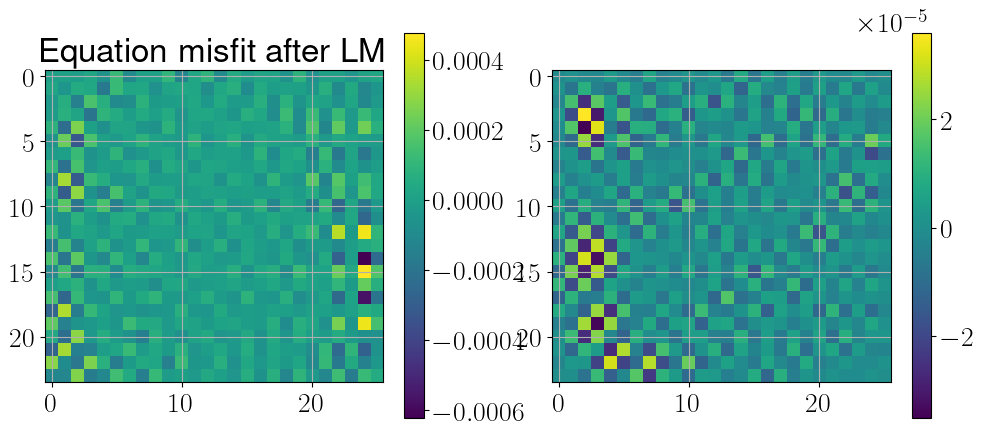

Pre Refinement  1.0712492983130565e-08
Post Refinement  9.01177578779333e-11


In [62]:
equation_residuals = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(params),EqnModel.get_P_params(params)
    )

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.grid(None)
plt.colorbar()
plt.subplot(1,2,2)

equation_residuals_refined = EqnModel.stacked_equation_residual(
    EqnModel.get_u_params(p_adjusted),EqnModel.get_P_params(p_adjusted)
    )
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

,NRMSE,NMAE
1 Step,0.003575,0.002967
2 Step,0.738156,0.681482


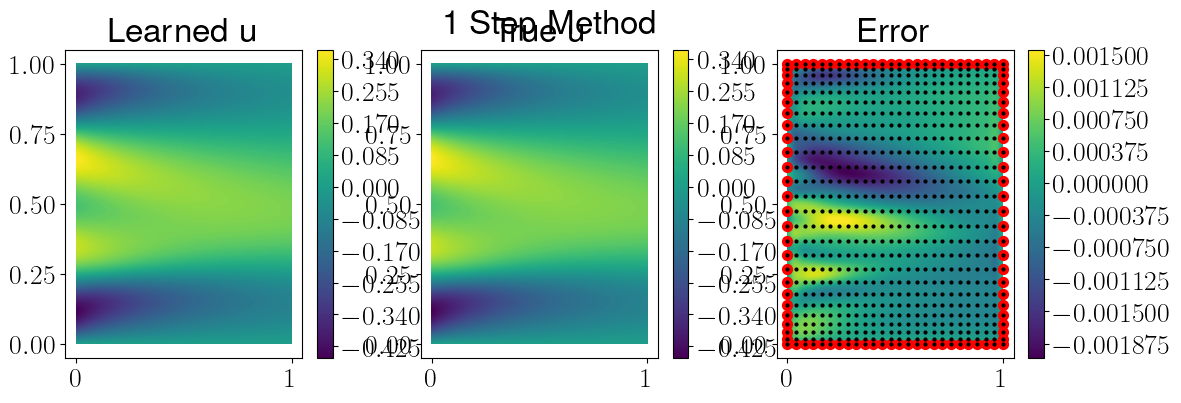

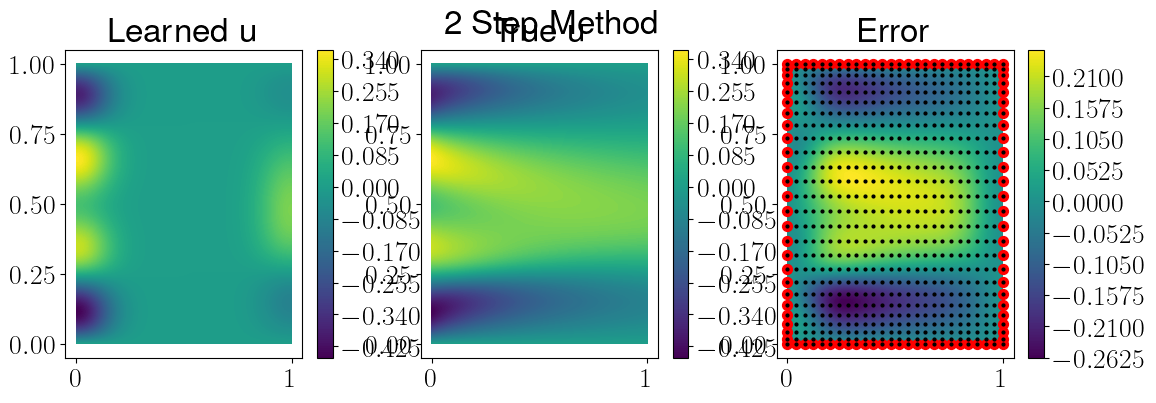

In [63]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

## Images for the paper

In [64]:
def plot_function(
    obs_points,
    all_points,
    func,
    fine_grid,
    vmin,
    vmax,
    xlabel = '',
    ylabel = '',
    level_sets = 70,
    include_collocation = True,
    include_observations = True
):
    plt.figure(figsize=(5,4))
    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(*fine_grid.T,func(fine_grid),level_sets, vmin = vmin, vmax = vmax)
    # cb = plt.colorbar()
    # tick_locator = ticker.MaxNLocator(nbins=4)
    # cb.locator = tick_locator
    # cb.update_ticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=4)
    plt.tight_layout()
    if include_collocation is True:
        plt.scatter(*all_points.T,c='gray',s = 3,label = "Collocation Point")
    if include_observations is True:
        plt.scatter(*obs_points.T,c='red', s = 50, alpha = 0.5,label = "Function Value Observed")


In [65]:
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

-0.4532077296610373
0.3624836284745666


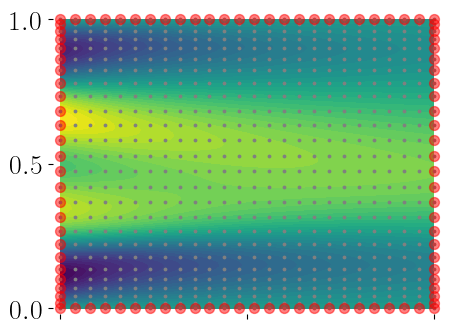

In [66]:
# True
vmin = min(u_true_function(tx_fine))
print(vmin)
vmax = max(u_true_function(tx_fine))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
    level_sets=50,
    vmin=-0.4532246910384856,
    vmax=0.36374402
)
plt.gca().set_xticklabels([]) 
plt.savefig('onlydbry_u_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

-0.4532246910384856
0.3627341827377677


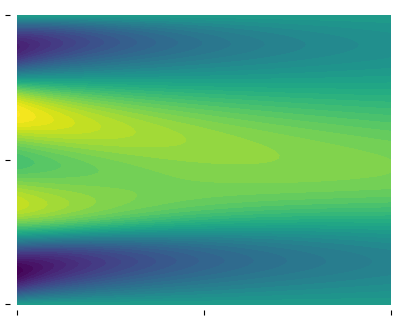

In [67]:
# 1-step
vmin = min(u_model.point_evaluate(tx_fine,u_sol))
print(vmin)
vmax = max(u_model.point_evaluate(tx_fine,u_sol))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid_pts: u_model.point_evaluate(grid_pts,u_sol),
    tx_fine,
    vmin=-0.4532077296610373,
    vmax=0.36374402,
    level_sets=50,
    include_collocation= False,
    include_observations= False
)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('onlydbry_u_pred_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

-0.45318976584686355
0.36248371113768263


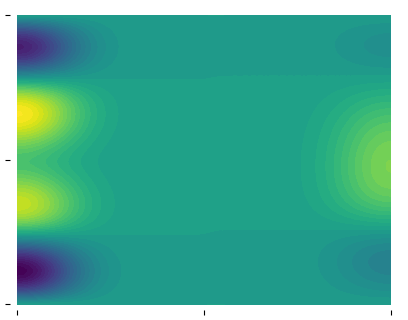

In [68]:
# 2-step
vmin = min(u_model.point_evaluate(tx_fine,u_params_init))
print(vmin)
vmax = max(u_model.point_evaluate(tx_fine,u_params_init))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid_pts: u_model.point_evaluate(grid_pts,u_params_init),
    tx_fine,
    level_sets=50,
    vmin = -0.4532077296610373,
    vmax = 0.36374402,
    include_collocation= False,
    include_observations= False
)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('onlydbry_u_pred_interp.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

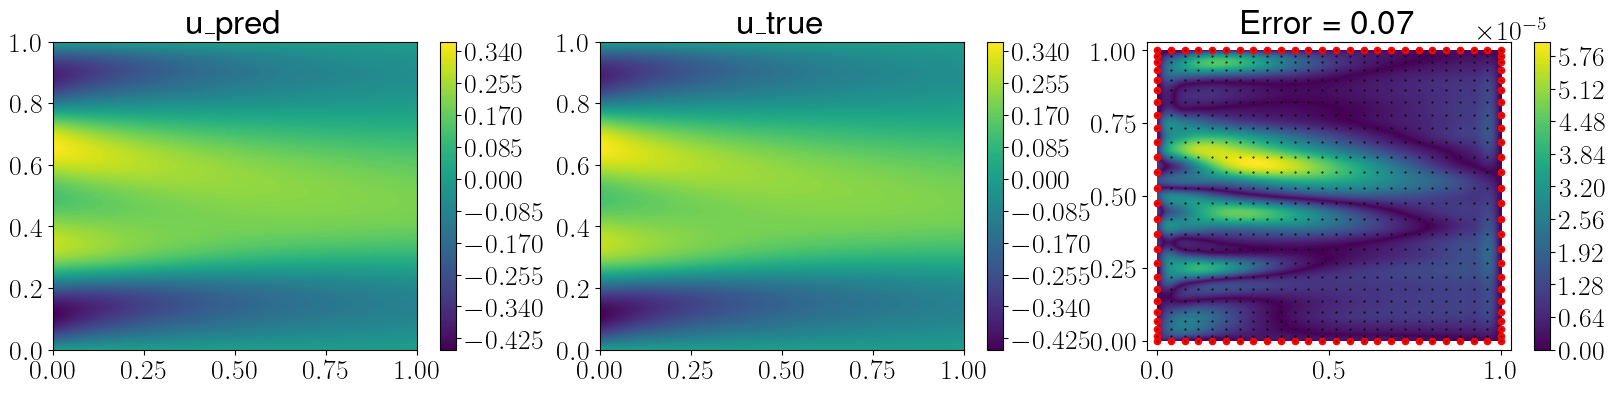

In [69]:
# Plot results for 1 step
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# fig.suptitle('Filtering u')
pred = u_model.point_evaluate(tx_grid_fine,u_sol)
# true = data_in_PINNSR[0].flatten()
true = u_true_function(tx_grid_fine)
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.savefig('1_step_burgers_bdrydata',dpi = 300)
plt.show()

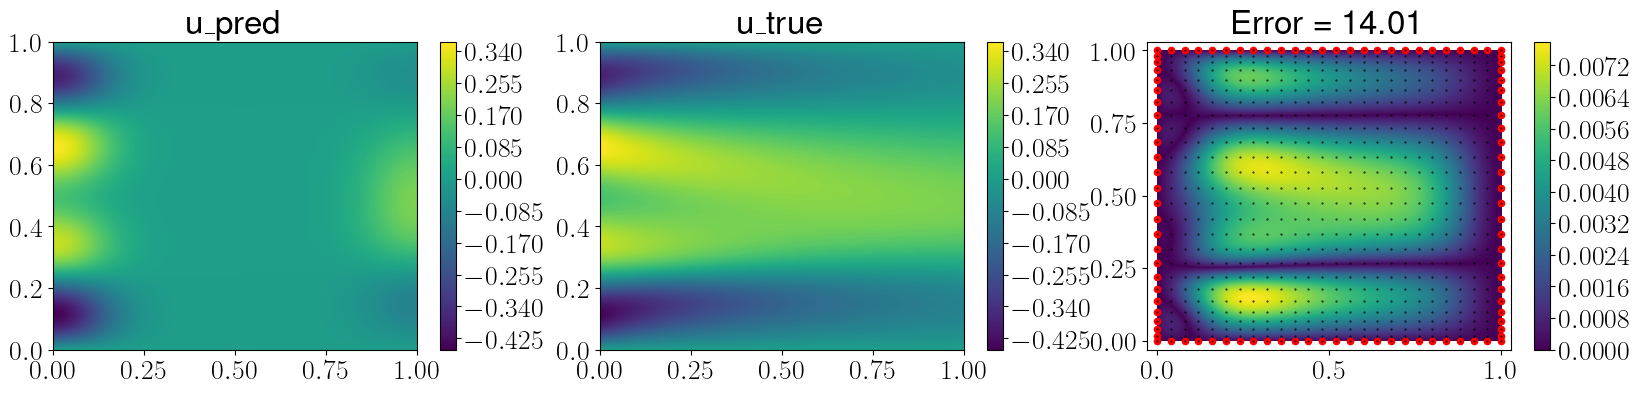

In [70]:
# Plot results for 2 step
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# fig.suptitle('2 step method u recovery on Burgers experiment ONLY with boundary data')
pred = u_model.point_evaluate(tx_grid_fine,u_params_init)
# true = data_in_PINNSR[0].flatten()
true = u_true_function(tx_grid_fine)
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.savefig('2_step_burgers_bdrydata',dpi = 300)
plt.show()

### Testing on new ICs from GP

In [71]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 3050.53it/s]


In [72]:
def get_u_pde_adj(u0_new,method):
    
    model_grid_features = EqnModel.single_eqn_features(u_model,u_sol,tx_int)
    # Phat of 1 step method
    @jit
    def get_pred_ut(input_features):
        return P_model.kernel_function(input_features,model_grid_features)@P_sol
    # Phat of 2 step method
    @jit
    def get_pred_ut_2step(input_features):
        init_P_features = EqnModel.single_eqn_features(u_model,u_params_init,tx_int)
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
        return P_model.predict_new(input_features,init_P_features,P_params_naive)

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = jnp.where(method == 1, get_pred_ut(P_features), get_pred_ut_2step(P_features))
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    import Optimizers
    import importlib
    importlib.reload(Optimizers)
    from Optimizers import (
        CholeskyLM,SVD_LM,LMParams,plot_optimization_results
    )

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_sol

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,EqnModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj 

In [73]:
# Define grid to test
true = new_u_true_function(tx_grid_fine)
u_params_newIC_1step = get_u_pde_adj(new_u_true_function,method=1)
pred1_5 = u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step)

u_params_newIC_2step = get_u_pde_adj(new_u_true_function,method=2)
pred2 = u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step)

i_opt_1_5 = get_nrmse(true,pred1_5)
i_opt_2 = get_nrmse(true,pred2)

  2%|▏         | 4/251 [00:32<25:32,  6.20s/it]  

Iteration 0, loss = 0.05608, gradnorm = 145.2, alpha = 0.04167, improvement_ratio = 0.9991
Iteration 1, loss = 0.003896, gradnorm = 0.2665, alpha = 0.03472, improvement_ratio = 0.9306
Iteration 2, loss = 1.06e-05, gradnorm = 0.04026, alpha = 0.02894, improvement_ratio = 0.9996
Iteration 3, loss = 4.354e-06, gradnorm = 0.0009716, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 3.736e-06, gradnorm = 3.564e-06, alpha = 0.02009, improvement_ratio = 1.0


  4%|▍         | 10/251 [00:33<06:40,  1.66s/it]

Iteration 5, loss = 3.28e-06, gradnorm = 2.517e-06, alpha = 0.01674, improvement_ratio = 1.0


 22%|██▏       | 55/251 [00:34<00:09, 20.33it/s]

Iteration 50, loss = 6e-08, gradnorm = 1.494e-08, alpha = 4.579e-06, improvement_ratio = 1.0


 41%|████      | 103/251 [00:37<00:06, 21.92it/s]

Iteration 100, loss = 4.17e-09, gradnorm = 1.599e-07, alpha = 3.821e-09, improvement_ratio = 1.002


 61%|██████▏   | 154/251 [00:39<00:04, 21.66it/s]

Iteration 150, loss = 2.29e-09, gradnorm = 5.799e-07, alpha = 4.711e-09, improvement_ratio = 0.9978


 82%|████████▏ | 205/251 [00:41<00:02, 21.56it/s]

Iteration 200, loss = 1.63e-09, gradnorm = 4.351e-07, alpha = 3.873e-09, improvement_ratio = 1.0


100%|██████████| 251/251 [00:43<00:00,  5.71it/s]


Iteration 250, loss = 1.342e-09, gradnorm = 5.98e-07, alpha = 4.777e-09, improvement_ratio = 1.023


  0%|          | 0/201 [00:24<?, ?it/s]

Line Search Failed!
Final Iteration Results
Iteration 0, loss = 5.413e+09, gradnorm = 1.228e+09, alpha = 2.541e-05, improvement_ratio = -22.71



  1%|          | 3/251 [00:40<43:16, 10.47s/it]  

Iteration 0, loss = 8.045e-07, gradnorm = 145.2, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 3.36e-07, gradnorm = 1.077e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 2.173e-07, gradnorm = 1.085e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 1.573e-07, gradnorm = 6.004e-07, alpha = 0.02411, improvement_ratio = 1.0


  3%|▎         | 8/251 [00:40<09:57,  2.46s/it]

Iteration 4, loss = 1.201e-07, gradnorm = 4.156e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 9.486e-08, gradnorm = 3.128e-07, alpha = 0.01674, improvement_ratio = 1.0


  1%|          | 2/201 [00:24<33:07,  9.99s/it]  

Iteration 0, loss = 5.388e+05, gradnorm = 4.789e+06, alpha = 0.1153, improvement_ratio = 0.4868
Iteration 1, loss = 1.373e+05, gradnorm = 3.251e+06, alpha = 0.1153, improvement_ratio = 0.7452


  2%|▏         | 4/201 [00:24<11:01,  3.36s/it]

Iteration 2, loss = 1.672e+04, gradnorm = 1.089e+06, alpha = 0.07206, improvement_ratio = 0.8782
Iteration 3, loss = 355.5, gradnorm = 1.684e+05, alpha = 0.04504, improvement_ratio = 0.9789


  3%|▎         | 6/201 [00:24<04:48,  1.48s/it]

Iteration 4, loss = 97.18, gradnorm = 4.167e+03, alpha = 0.04504, improvement_ratio = 0.7295
Iteration 5, loss = 67.83, gradnorm = 1.115e+03, alpha = 0.04504, improvement_ratio = 0.3109


 26%|██▌       | 52/201 [00:29<00:16,  8.78it/s]

Iteration 50, loss = 14.48, gradnorm = 2.542, alpha = 405.0, improvement_ratio = 0.05782


 51%|█████     | 102/201 [00:35<00:11,  8.73it/s]

Iteration 100, loss = 14.39, gradnorm = 1.685, alpha = 607.5, improvement_ratio = 0.1741


 76%|███████▌  | 152/201 [00:41<00:05,  8.74it/s]

Iteration 150, loss = 14.37, gradnorm = 0.832, alpha = 607.5, improvement_ratio = 0.1118


 83%|████████▎ | 167/201 [00:43<00:03,  8.65it/s]

Line Search Failed!
Final Iteration Results
Iteration 167, loss = 14.37, gradnorm = 0.6135, alpha = 2.66e+05, improvement_ratio = 0.04853


 83%|████████▎ | 167/201 [00:43<00:08,  3.84it/s]


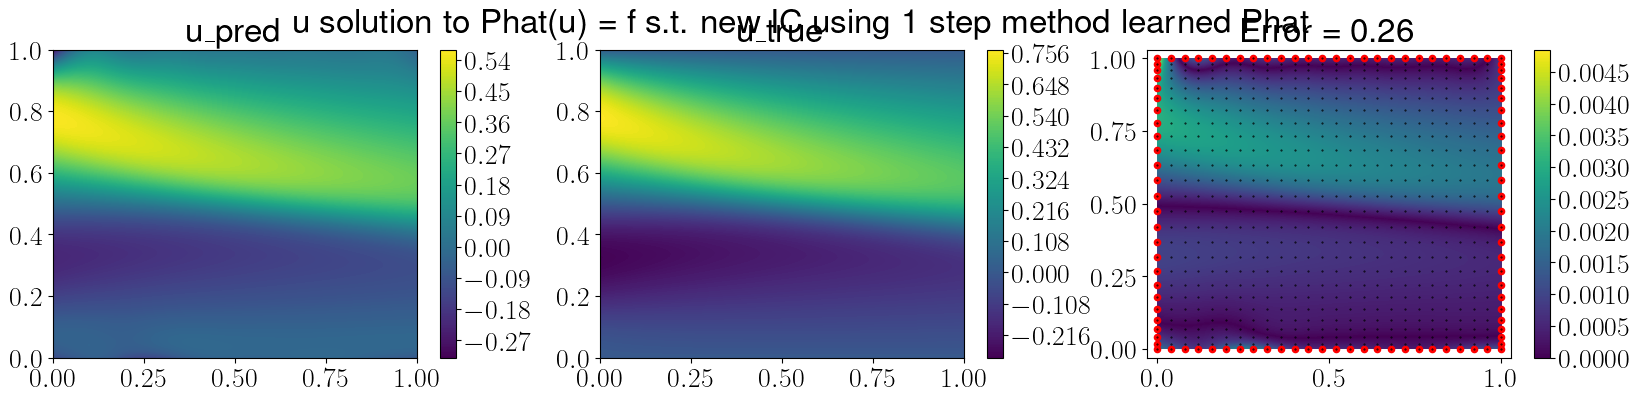

In [74]:
# Plot results for 1 step operator learning error
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
fig.suptitle('u solution to Phat(u) = f s.t. new IC using 1 step method learned Phat')
a1 = ax1.tricontourf(*tx_grid_fine.T,pred1_5,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred1_5 - true)/(jnp.linalg.norm(true)),200)
err_1_step = jnp.linalg.norm(pred1_5 - true,2)/(jnp.linalg.norm(true,2))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(err_1_step,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
# plt.savefig('1_step_initial_final_operator_prediction',dpi = 300)
plt.show()

-0.2896012968704471
0.7661834960783577


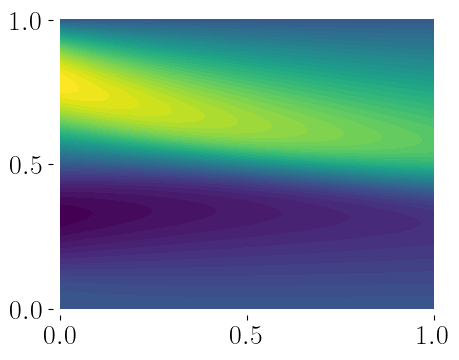

In [75]:
# True with new IC
vmin = min(new_u_true_function(tx_grid_fine))
print(vmin)
vmax = max(new_u_true_function(tx_grid_fine))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    new_u_true_function,
    tx_grid_fine,
    level_sets=50,
    vmin=vmin,
    vmax=vmax,
    include_collocation= False,
    include_observations=False
)
# plt.gca().set_xticklabels([]) 
plt.savefig('onlydbry_newIC_u_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

-0.31847804854623973
0.565102226799354


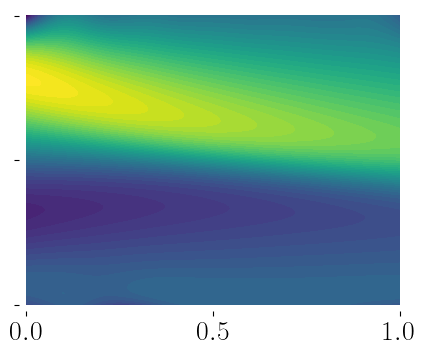

In [76]:
# 1step- with new IC
vmin = min(u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step))
print(vmin)
vmax = max(u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid: u_model.point_evaluate(grid,u_params_newIC_1step),
    tx_grid_fine,
    level_sets=50,
    vmin=vmin,
    vmax=vmax,
    include_collocation= False,
    include_observations=False
)
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_newIC_u_pred_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

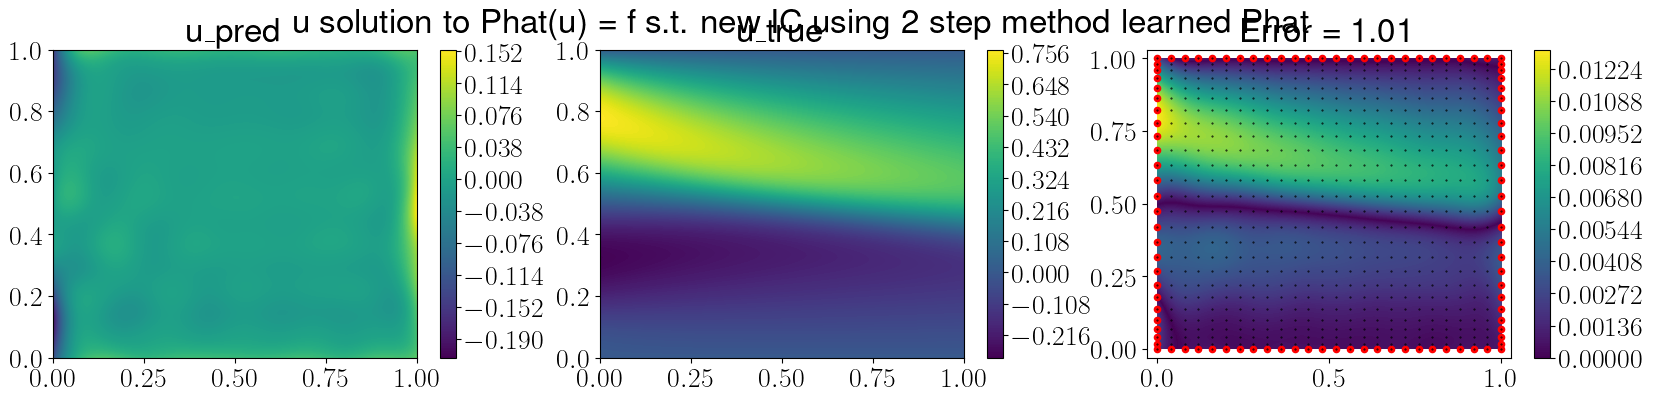

In [33]:
# Plot results for 2 step operator learning error
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
fig.suptitle('u solution to Phat(u) = f s.t. new IC using 2 step method learned Phat')
a1 = ax1.tricontourf(*tx_grid_fine.T,pred2,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred2 - true)/(jnp.linalg.norm(true)),200)
err_2_step = jnp.linalg.norm(pred2 - true,2)/(jnp.linalg.norm(true,2))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(err_2_step,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
# plt.savefig('1_step_initial_final_operator_prediction',dpi = 300)
plt.show()

-0.2110553033509177
0.15275596620722354


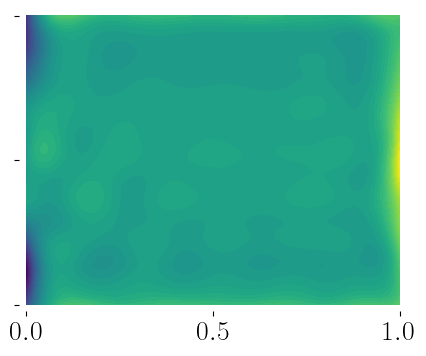

In [34]:
# 2 step- with new IC
vmin = min(u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step))
print(vmin)
vmax = max(u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid: u_model.point_evaluate(grid,u_params_newIC_2step),
    tx_grid_fine,
    level_sets=50,
    vmin=vmin,
    vmax=vmax,
    include_collocation= False,
    include_observations=False
)
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_newIC_u_pred_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

## PINN-SR

In [4]:
from plotting import plot_input_data
def get_data_for_pinns(n_coll_t, n_coll_x):
    # Solve Burgers' equations with IC u_0_true_function
    k = 5e-4
    kappa = 0.01
    alpha = 0.5
    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0

    u_true_function,ut_true_function,interpolant,t_vals,sols = (
        build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                            )
    
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],n_coll_t,n_coll_x,alpha = 0.5)

    # Get (X^m, u^m(X^m))
    tx_all = jnp.vstack([tx_bdy,tx_int])

    #Observe on initial+final+boundary
    init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
    num_init_obs_inds = len(init_obs_inds)
    final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
    u_true = u_true_function(tx_all)

    x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
    tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
    u_obs = u_true_function(tx_obs)
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs 
    u_train = u_true_function(tx_train) 
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    # plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)
    
    plot_input_data(
        tx_train, 
        tx_all,
        u_true_function,
        tx_fine,
                )

    num_fine_grid = 200
    t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
    tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plt.title('u_true')
    
    u_true = u_true_function(tx_grid_fine)
    # plt.tricontourf(*tx_fine_int.T, u_true,200)
    # plt.colorbar()
    # plt.xlabel('t')
    # plt.ylabel('x')


    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [u_true, tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  2%|▏         | 187/10099 [00:00<00:05, 1866.29it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2948.88it/s]


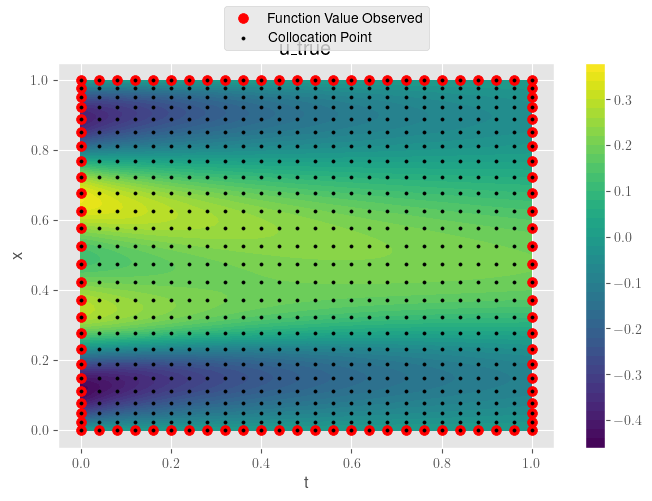

In [5]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

data_in_PINNSR = get_data_for_pinns(n_coll_t = 26, n_coll_x = 26)
data_in_PINNSR = list(map(np.array,data_in_PINNSR))

In [85]:
np.save('data_in_PINNSR.npy', np.array(data_in_PINNSR, dtype=object), allow_pickle=True)

In [6]:
data_out_PINNSR = jnp.load('data_out_PINNSR.npy',allow_pickle = True)

In [7]:
data_out_PINNSR[1]

array([[-0.0050323 ],
       [-0.00481486],
       [-0.00461221],
       ...,
       [-0.00035596],
       [-0.0003314 ],
       [-0.00030708]], dtype=float32)

In [11]:
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

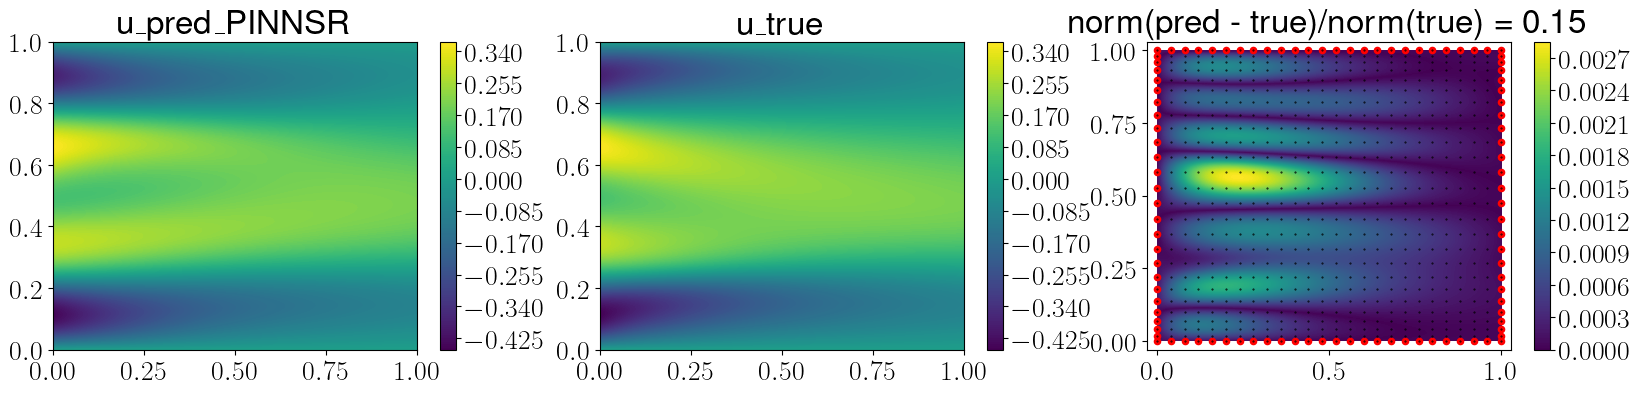

In [12]:
# Plot results for PINNSR 
num_fine_grid = 200
final_time=1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# fig.suptitle('PINNSR u recovery on Burgers experiment ONLY with boundary data')
pred = data_out_PINNSR[1].flatten()
true = data_in_PINNSR[0].flatten()
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred_PINNSR')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,2))
ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.show()

-0.45030534
0.36374402


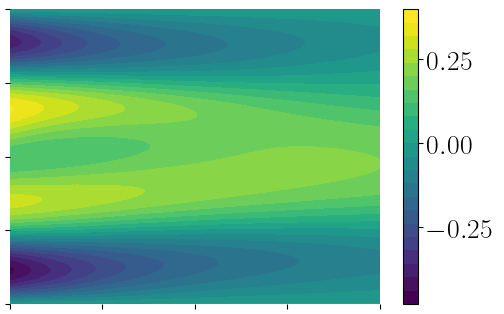

In [13]:
plt.figure(figsize=(6,4))
x_bounds = jnp.min(tx_grid_fine[:,0]),jnp.max(tx_grid_fine[:,0])
y_bounds = jnp.min(tx_grid_fine[:,1]),jnp.max(tx_grid_fine[:,1])
pred = data_out_PINNSR[1].flatten()
print(pred.min())
print(pred.max())
cp = plt.tricontourf(*tx_grid_fine.T,pred,20,vmin= -0.4532077296610373, vmax=0.36374402)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# plt.xlabel(r'$t$')
# plt.ylabel(r'$x$')
plt.xlim(x_bounds[0],x_bounds[1])
plt.ylim(y_bounds[0],y_bounds[1])

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=4)

plt.tight_layout()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_u_pred_PINNSR.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

## Testing on new ICs

In [14]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 2899.30it/s]


In [15]:
from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF,
    get_anisotropic_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k


u_operators = (eval_k,dx_k,dt_k,dxx_k)
# u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,
                     dx_k,
                     dxx_k)

k_u = get_gaussianRBF(jnp.sqrt(0.025/2))


u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

In [21]:
jnp.array([1.,3.]) @ jnp.array([1.,2.])

Array(7., dtype=float64)

In [22]:
data_out_PINNSR[0].flatten()

array([ 0.05229474, -1.5196832 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32)

In [25]:
def get_u_pde_adj(u0_new):
    
    # Phat of 2 step method
    @jit
    def get_pred_ut_PINNSR(input_features):

        coeffs = data_out_PINNSR[0].flatten()

        return input_features @ coeffs

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            CONST = jnp.ones(len(tx_int))
            
            U = grid_features[:,0]
            U_x = grid_features[:,1]
            U_xx = grid_features[:,2]
            
            UU = jnp.multiply(U,U)
            UU_x = jnp.multiply(U,U_x)
            UU_xx = jnp.multiply(U,U_xx)

            U_xU_x = jnp.multiply(U_x,U_x)
            U_xU_xx = jnp.multiply(U_x,U_xx)
            U_xxU_xx = jnp.multiply(U_xx,U_xx)
            

            full_features = jnp.vstack([CONST,U,U_x,U_xx,
                        UU,UU_x,UU_xx,U_xU_x,
                        U_xU_xx,U_xxU_xx]).T
            
            return full_features
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut_PINNSR(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    import Optimizers
    import importlib
    importlib.reload(Optimizers)
    from Optimizers import (
        CholeskyLM,SVD_LM,LMParams,plot_optimization_results
    )

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_params_init

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,PdeModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj

In [30]:
# Define grid to test
true = new_u_true_function(tx_grid_fine)
u_params_newIC_PINNSR = get_u_pde_adj(new_u_true_function)
pred_PINNSR = u_model.point_evaluate(tx_grid_fine,u_params_newIC_PINNSR)

  2%|▏         | 6/251 [00:28<14:05,  3.45s/it]  

Iteration 0, loss = 7.22e-06, gradnorm = 145.1, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 5.009e-06, gradnorm = 1.119e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 4.021e-06, gradnorm = 2.511e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 3.492e-06, gradnorm = 1.671e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 3.176e-06, gradnorm = 1.25e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.947e-06, gradnorm = 9.88e-07, alpha = 0.01674, improvement_ratio = 1.0


 24%|██▎       | 59/251 [00:29<00:11, 16.71it/s]

Iteration 50, loss = 2.107e-07, gradnorm = 4.087e-08, alpha = 4.579e-06, improvement_ratio = 1.0


 42%|████▏     | 106/251 [00:30<00:03, 43.66it/s]

Iteration 100, loss = 5.875e-10, gradnorm = 3.224e-07, alpha = 5.731e-09, improvement_ratio = 0.9984


 62%|██████▏   | 156/251 [00:31<00:02, 46.95it/s]

Iteration 150, loss = 3.097e-10, gradnorm = 3.948e-07, alpha = 4.711e-09, improvement_ratio = 1.008


 82%|████████▏ | 206/251 [00:32<00:00, 46.68it/s]

Iteration 200, loss = 2.427e-10, gradnorm = 2.65e-07, alpha = 5.81e-09, improvement_ratio = 0.9923


100%|██████████| 251/251 [00:33<00:00,  7.58it/s]


Iteration 250, loss = 2.036e-10, gradnorm = 4.02e-07, alpha = 4.777e-09, improvement_ratio = 1.021


  1%|▏         | 3/201 [00:25<22:08,  6.71s/it]  

Iteration 0, loss = 2.413e-10, gradnorm = 3.359e-07, alpha = 1.722e-07, improvement_ratio = 8.601
Iteration 1, loss = 2.413e-10, gradnorm = 1.321e-07, alpha = 8.171e-07, improvement_ratio = 14.8
Iteration 2, loss = 2.413e-10, gradnorm = 1.699e-07, alpha = 7.66e-07, improvement_ratio = 10.74


  1%|▏         | 3/201 [00:25<28:30,  8.64s/it]

Line Search Failed!
Final Iteration Results
Iteration 3, loss = 2.413e-10, gradnorm = 1.699e-07, alpha = 0.004076, improvement_ratio = -182.9


In [32]:
i_opt_PINNSR = get_nrmse(true,pred_PINNSR)
i_opt_PINNSR

Array(0.47261285, dtype=float64)

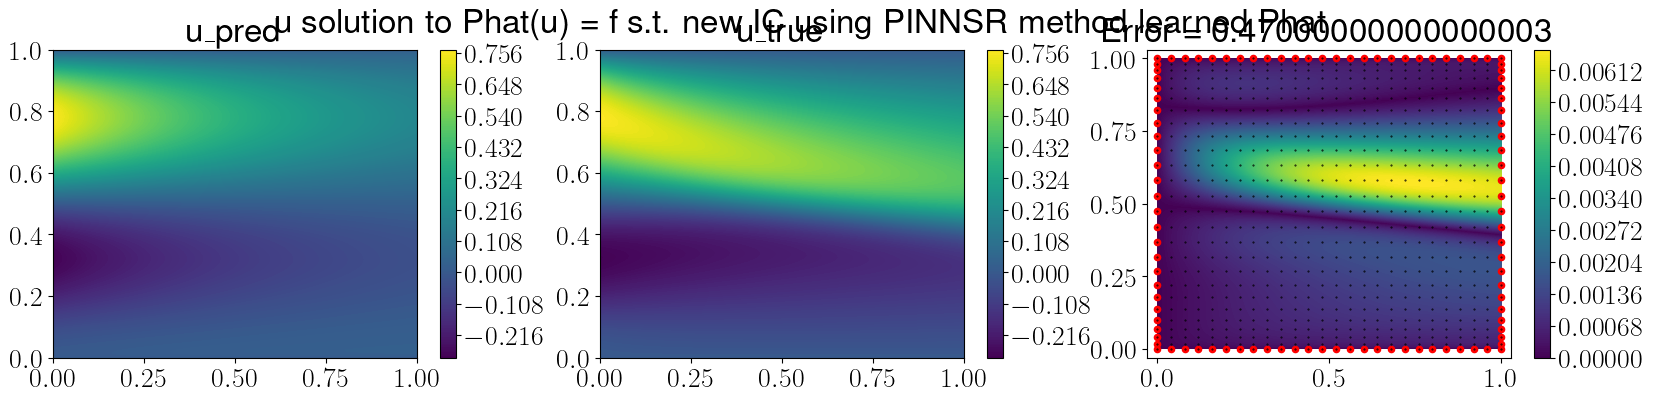

In [33]:
# Plot results for 1 step operator learning error
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
fig.suptitle('u solution to Phat(u) = f s.t. new IC using PINNSR method learned Phat')
a1 = ax1.tricontourf(*tx_grid_fine.T,pred_PINNSR,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred_PINNSR - true)/(jnp.linalg.norm(true)),200)
err_PINNSR = jnp.linalg.norm(pred_PINNSR - true,2)/(jnp.linalg.norm(true,2))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(err_PINNSR,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
# plt.savefig('1_step_initial_final_operator_prediction',dpi = 300)
plt.show()

-0.2895997883169912
0.7661837709601969


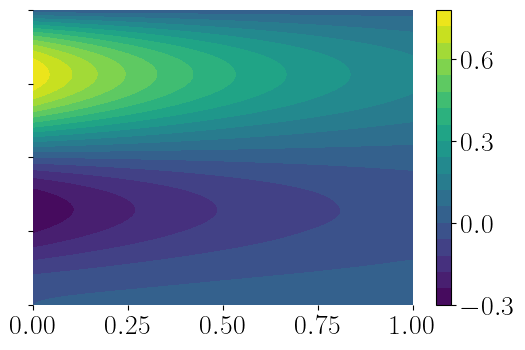

In [42]:
plt.figure(figsize=(6,4))
x_bounds = jnp.min(tx_grid_fine[:,0]),jnp.max(tx_grid_fine[:,0])
y_bounds = jnp.min(tx_grid_fine[:,1]),jnp.max(tx_grid_fine[:,1])
pred = u_model.point_evaluate(tx_grid_fine,u_params_newIC_PINNSR)
print(pred.min())
print(pred.max())
# cp = plt.tricontourf(*tx_grid_fine.T,pred,20,vmin= -0.4532077296610373, vmax=0.36374402)
cp = plt.tricontourf(*tx_grid_fine.T,pred,20)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# plt.xlabel(r'$t$')
# plt.ylabel(r'$x$')
plt.xlim(x_bounds[0],x_bounds[1])
plt.ylim(y_bounds[0],y_bounds[1])

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=4)

plt.tight_layout()
# plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_newIC_u_pred_PINNSR.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )